In [1]:
%matplotlib inline
from config_calc import *
import grid_tools

from collections import OrderedDict

import cesm_orcas_sci as cesm
import cam
import gv
import metpy.calc as mcalc

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

### read model dataset

In [2]:
case = 'bgeos5.B20TRC5CN.f09_g16.BPRD_orcas_sci.004'

tracer_def = cesm.trace_gas_tracers(case)
tracer_3d = [k for k in tracer_def]
tracer_3d = ['CO2','CO2_OCN','CO2_FFF','CO2_LND','O2_OCN']
varlist = ['Z3','PS']+tracer_3d

dsa = cesm.open_casedata(case,'atm','cam.h0',varlist)
dsa

<xarray.Dataset>
Dimensions:       (ilev: 57, lat: 192, lev: 56, lon: 288, nbnd: 2, slat: 191, slon: 288, time: 3347)
Coordinates:
  * ilev          (ilev) float64 1.651 2.085 2.62 3.276 4.077 5.047 6.217 ...
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 ...
  * lev           (lev) float64 1.868 2.353 2.948 3.677 4.562 5.632 6.918 ...
  * lon           (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 ...
  * slat          (slat) float64 -89.53 -88.59 -87.64 -86.7 -85.76 -84.82 ...
  * slon          (slon) float64 -0.625 0.625 1.875 3.125 4.375 5.625 6.875 ...
  * time          (time) datetime64[ns] 2007-01-01 2007-01-02 2007-01-03 ...
Dimensions without coordinates: nbnd
Data variables:
    P0            float64 1e+05
    Z3            (time, lev, lat, lon) float32 ...
    ch4vmr        (time) float64 1.757e-06 1.757e-06 1.757e-06 1.757e-06 ...
    co2vmr        (time) float64 0.0003818 0.0003818 0.0003818 0.0003818 ...
    date          (time) int32 20

### read points
File recieved via email from Colm Sweeny in Jan 2018.

I had to modify the file to make the time units CF compliant using
```
ncatted -a units,Time,o,c,"days since 2000-01-01 00:00:00" ECMWF_ORCAS_endpoints.nc
```

In [3]:
dsp = xr.open_dataset('/glade/p/work/mclong/orcas/ecmwf_points/ECMWF_ORCAS_endpoints.nc')
dsp.sample.values = np.arange(0,len(dsp.sample),1)
dsp = dsp.sortby('Time',ascending=True)
dsp = dsp.compute()
dsp

<xarray.Dataset>
Dimensions:    (sample: 180218)
Coordinates:
  * sample     (sample) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Data variables:
    Latitude   (sample) float64 75.12 3.52 -18.78 -5.946 29.95 12.81 -56.52 ...
    Longitude  (sample) float64 -66.95 -143.2 -63.92 -178.6 -10.44 -160.4 ...
    Alt        (sample) float64 8.683e+03 5.411e+03 3.687e+03 1.336e+04 ...
    Time       (sample) datetime64[ns] 2015-11-01T15:00:00 ...
Attributes:
    history:  Wed Jan 24 06:36:21 2018: ncatted -a units,Time,o,c,days since ...
    NCO:      4.6.9

### plot the data so we can see what we're dealing with

Text(0,1,u'Alt')

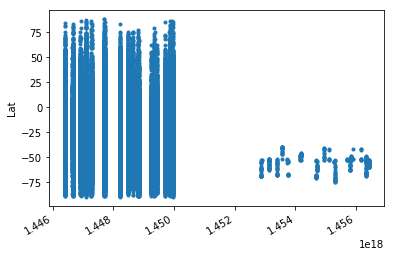

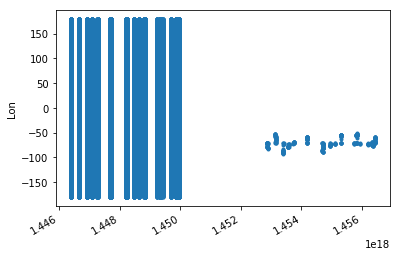

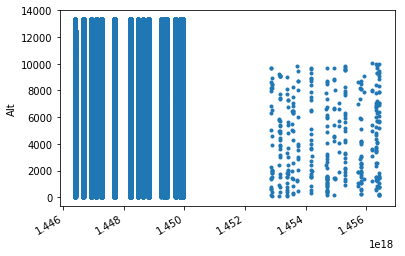

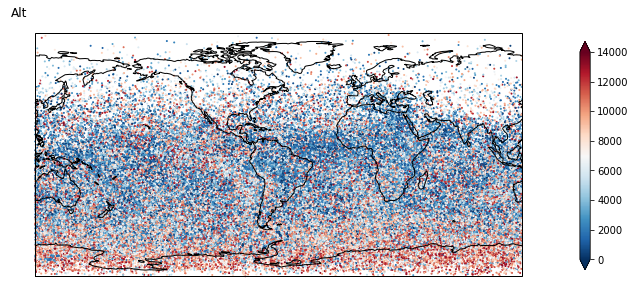

In [4]:
fig = plt.figure()

plt.plot(dsp.Time,dsp.Latitude,'.')
plt.gcf().autofmt_xdate()
plt.gca().set_ylabel('Lat')

fig = plt.figure()
plt.plot(dsp.Time,dsp.Longitude,'.')
plt.gcf().autofmt_xdate()
plt.gca().set_ylabel('Lon')

fig = plt.figure()
plt.plot(dsp.Time,dsp.Alt,'.')
plt.gcf().autofmt_xdate()
plt.gca().set_ylabel('Alt')

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=300))
sc = plt.scatter(dsp.Longitude,dsp.Latitude,
                 c=dsp.Alt, s=1,
                 vmin=0,vmax=14e3,
                 cmap='RdBu_r',
                 transform=ccrs.PlateCarree())
plt.colorbar(sc,shrink=0.7,extend='both')
ax.coastlines()
ax.set_title('Alt',loc='left')

In [5]:
#-- find the unique days
uniday = np.unique(dsp.Time.values.astype('M8[D]'))
uniday

array(['2015-11-01', '2015-11-04', '2015-11-07', '2015-11-09',
       '2015-11-11', '2015-11-16', '2015-11-17', '2015-11-22',
       '2015-11-25', '2015-11-27', '2015-11-29', '2015-11-30',
       '2015-12-04', '2015-12-05', '2015-12-06', '2015-12-10',
       '2015-12-11', '2015-12-12', '2016-01-15', '2016-01-18',
       '2016-01-21', '2016-01-23', '2016-01-25', '2016-01-30',
       '2016-02-05', '2016-02-08', '2016-02-10', '2016-02-12',
       '2016-02-17', '2016-02-18', '2016-02-19', '2016-02-22',
       '2016-02-23', '2016-02-24', '2016-02-25'], dtype='datetime64[D]')

### subset model dataset for each day 

In [6]:
%%time
MDL = []
for day in uniday:
    MDL.append(dsa.sel(time=day,method='nearest'))
dss = xr.concat(MDL,dim='time')
print dss

<xarray.Dataset>
Dimensions:       (ilev: 57, lat: 192, lev: 56, lon: 288, nbnd: 2, slat: 191, slon: 288, time: 35)
Coordinates:
  * ilev          (ilev) float64 1.651 2.085 2.62 3.276 4.077 5.047 6.217 ...
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 ...
  * lev           (lev) float64 1.868 2.353 2.948 3.677 4.562 5.632 6.918 ...
  * lon           (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 ...
  * slat          (slat) float64 -89.53 -88.59 -87.64 -86.7 -85.76 -84.82 ...
  * slon          (slon) float64 -0.625 0.625 1.875 3.125 4.375 5.625 6.875 ...
  * time          (time) datetime64[ns] 2015-11-01 2015-11-04 2015-11-07 ...
Dimensions without coordinates: nbnd
Data variables:
    P0            (time) float64 1e+05 1e+05 1e+05 1e+05 1e+05 1e+05 1e+05 ...
    Z3            (time, lev, lat, lon) float32 41723.4 41723.4 41723.4 ...
    ch4vmr        (time) float64 1.843e-06 1.843e-06 1.843e-06 1.843e-06 ...
    co2vmr        (time) float64 0.000402

In [7]:
%%time
ds = cesm.convert_dataset(dss.copy(),case)
ds = ds.compute()
print ds

<xarray.Dataset>
Dimensions:       (ilev: 57, lat: 192, lev: 56, lon: 288, nbnd: 2, slat: 191, slon: 288, time: 35)
Coordinates:
  * ilev          (ilev) float64 1.651 2.085 2.62 3.276 4.077 5.047 6.217 ...
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 ...
  * lev           (lev) float64 1.868 2.353 2.948 3.677 4.562 5.632 6.918 ...
  * lon           (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 ...
  * slat          (slat) float64 -89.53 -88.59 -87.64 -86.7 -85.76 -84.82 ...
  * slon          (slon) float64 -0.625 0.625 1.875 3.125 4.375 5.625 6.875 ...
  * time          (time) datetime64[ns] 2015-11-01 2015-11-04 2015-11-07 ...
Dimensions without coordinates: nbnd
Data variables:
    P0            (time) float64 1e+05 1e+05 1e+05 1e+05 1e+05 1e+05 1e+05 ...
    Z3            (time, lev, lat, lon) float32 41723.4 41723.4 41723.4 ...
    ch4vmr        (time) float64 1.843e-06 1.843e-06 1.843e-06 1.843e-06 ...
    co2vmr        (time) float64 0.000402

### interpolate model to get a column at each xy point for each unique day in the record

In [8]:
%%time
model_xy = []
for i,day in enumerate(uniday):
    var = [ds[v].isel(time=i) for v in varlist]
    model_xy.append(cam.interp_columns_esmf(dsp.Longitude,dsp.Latitude,
                                            ds.lon,ds.lat,*var))
print model_xy[0]

<xarray.Dataset>
Dimensions:  (lev: 56, sample: 180218)
Coordinates:
  * sample   (sample) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Dimensions without coordinates: lev
Data variables:
    O2_OCN   (sample, lev) float64 38.37 38.3 38.25 38.21 38.2 38.24 38.41 ...
    PS       (sample) float64 9.911e+04 1.011e+05 8.583e+04 1.011e+05 ...
    CO2      (sample, lev) float64 380.3 380.2 380.2 380.2 380.2 380.2 380.3 ...
    CO2_FFF  (sample, lev) float64 22.14 22.1 22.07 22.04 22.04 22.07 22.18 ...
    CO2_LND  (sample, lev) float64 2.031 2.028 2.026 2.024 2.023 2.026 2.034 ...
    CO2_OCN  (sample, lev) float64 -2.005 -1.996 -1.989 -1.982 -1.981 -1.988 ...
    Z3       (sample, lev) float64 4.009e+04 3.856e+04 3.71e+04 3.569e+04 ...
CPU times: user 9min 36s, sys: 6.69 s, total: 9min 43s
Wall time: 9min 45s


### interpolate within the column to get point of measurement
Interpolate the model fields for each unique day in the points data.

In [11]:
%%time
model_xyz = []
for i,day in enumerate(uniday):
    var = [model_xy[i][v] for v in varlist]
    model_xyz.append(cam.interp_within_column(dsp.Alt,model_xy[i].Z3,*var))
print model_xyz[0]

<xarray.Dataset>
Dimensions:  (sample: 180218)
Coordinates:
  * sample   (sample) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Data variables:
    O2_OCN   (sample) float64 63.98 54.73 56.07 58.32 71.56 62.3 50.35 60.55 ...
    PS       (sample) float64 9.911e+04 1.011e+05 8.583e+04 1.011e+05 ...
    CO2      (sample) float64 397.1 398.4 402.0 398.1 398.9 397.9 398.0 ...
    CO2_FFF  (sample) float64 46.06 46.02 46.07 46.46 50.4 47.52 44.98 46.9 ...
    CO2_LND  (sample) float64 0.01922 2.004 5.807 1.327 -1.718 -0.1956 3.086 ...
    CO2_OCN  (sample) float64 -7.207 -7.827 -7.979 -7.826 -7.957 -7.762 ...
    Z3       (sample) float64 8.683e+03 5.411e+03 3.687e+03 1.336e+04 492.3 ...
CPU times: user 13min 53s, sys: 97 ms, total: 13min 53s
Wall time: 13min 55s


### get data for correct date
For each unique day in points data, find the right interpolated model dataset and use the segment of that dataset corresponding to the right days.

In [12]:
dso = dsp.copy()
days = dsp.Time.values.astype('M8[D]')
for v in varlist:
    dso[v] = xr.DataArray(np.nan*np.ones((len(dsp.sample))),dims=('sample'),coords={'sample':dsp.sample})

for i,day in enumerate(uniday):
    nx = np.where(day == days)[0]
    for v in varlist:
        dso[v][nx] = model_xyz[i][v][nx]
dso

<xarray.Dataset>
Dimensions:    (sample: 180218)
Coordinates:
  * sample     (sample) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Data variables:
    Latitude   (sample) float64 75.12 3.52 -18.78 -5.946 29.95 12.81 -56.52 ...
    Longitude  (sample) float64 -66.95 -143.2 -63.92 -178.6 -10.44 -160.4 ...
    Alt        (sample) float64 8.683e+03 5.411e+03 3.687e+03 1.336e+04 ...
    Time       (sample) datetime64[ns] 2015-11-01T15:00:00 ...
    Z3         (sample) float64 8.683e+03 5.411e+03 3.687e+03 1.336e+04 ...
    PS         (sample) float64 9.911e+04 1.011e+05 8.583e+04 1.011e+05 ...
    CO2        (sample) float64 397.1 398.4 402.0 398.1 398.9 397.9 398.0 ...
    CO2_OCN    (sample) float64 -7.207 -7.827 -7.979 -7.826 -7.957 -7.762 ...
    CO2_FFF    (sample) float64 46.06 46.02 46.07 46.46 50.4 47.52 44.98 ...
    CO2_LND    (sample) float64 0.01922 2.004 5.807 1.327 -1.718 -0.1956 ...
    O2_OCN     (sample) float64 63.98 54.73 56.07 58.32 71.56 62.3 50.35 ...
Attribu

### save output to netCDF

In [13]:
file_out = os.path.join('/glade/p/work/mclong/orcas/ecmwf_points',case+'.'+'ECMWF_ORCAS_endpoints.nc')
dso.to_netcdf(file_out)

### plot scatter plots of all the fields

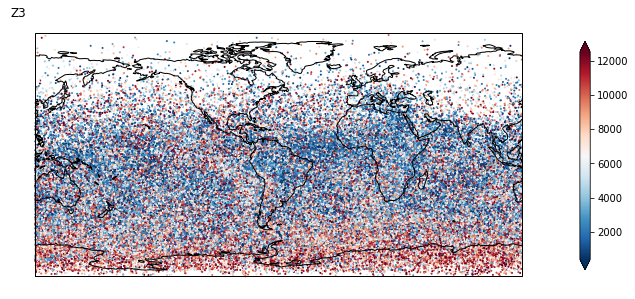

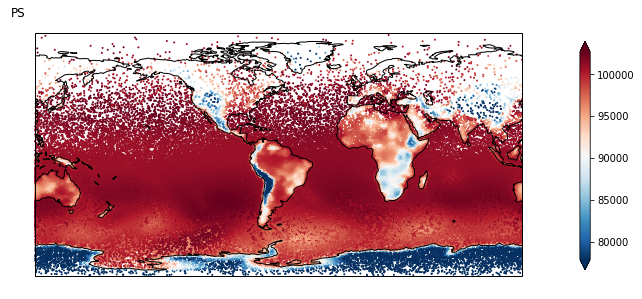

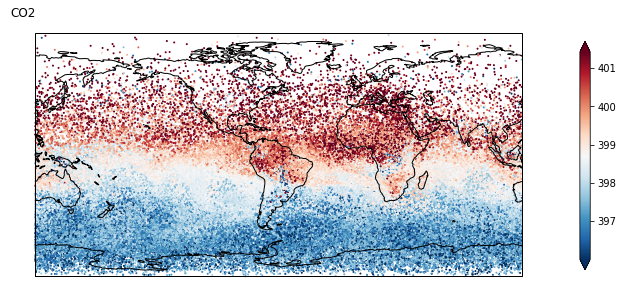

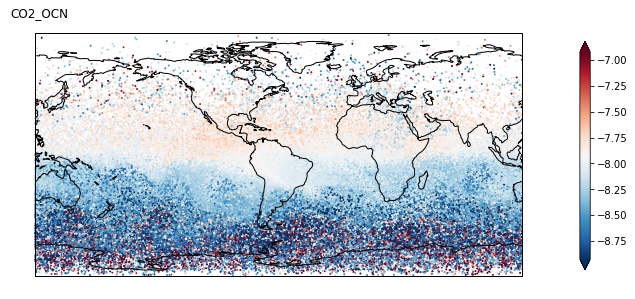

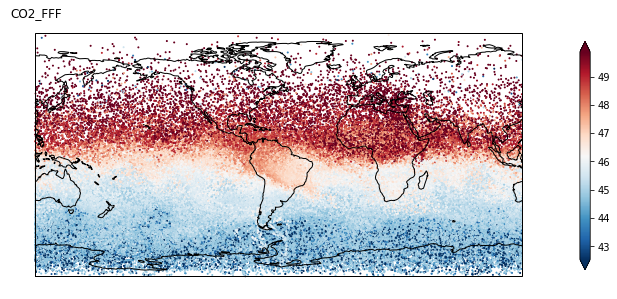

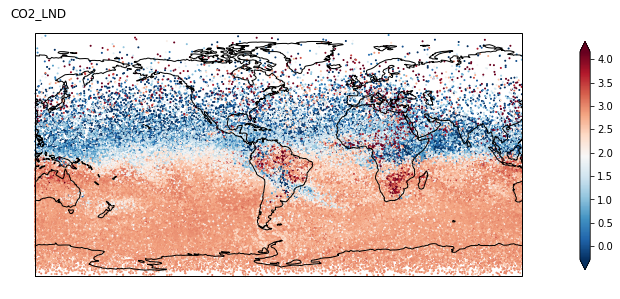

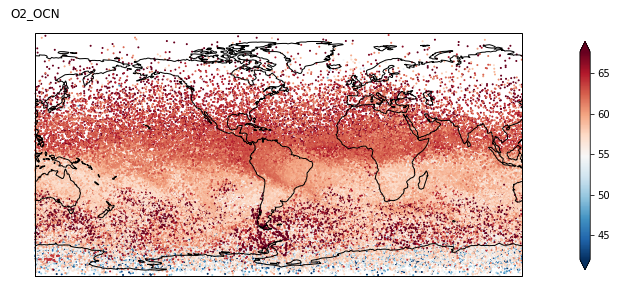

In [14]:
for v in varlist:
    vmin,vmax = np.nanpercentile(dso[v].values,[2.5,97.5])
    fig = plt.figure(figsize=(12,6))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=300))
    sc = plt.scatter(dso.Longitude,dso.Latitude,
                     c=dso[v], s=1,
                     vmin=vmin,vmax=vmax,
                     cmap='RdBu_r',
                     transform=ccrs.PlateCarree())
    plt.colorbar(sc,shrink=0.7,extend='both')
    ax.coastlines()
    ax.set_title(v,loc='left')

### check that the interpolated vertical coordinate matches the supplied interpolant
In some cases, points have an altitude that is below the model base.  The interpolation applied uses the models bottom cell value for interpolated fields at these points.

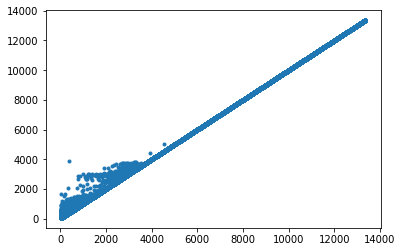

In [15]:
fig = plt.figure()
plt.plot(dso.Alt,dso.Z3,'.')